## 실습 목표

__1. 랜덤포레스트의 하이퍼파라미터가 어떤 것을 지칭하는지 확인__<br/> __2. 변수 중요도를 계산하고 시각화__<br/> __3. (과제) 랜덤포레스트로 회귀분석 실시하기__

In [1]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_table("BreastCancer.txt", sep=',')

In [3]:
df.head()

,ID,CT,UCS,UCSP,MA,SECS,BN,BC,NN,M,CLASS
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
df.describe()

,ID,CT,UCS,UCSP,MA,SECS,BC,NN,M,CLASS
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [45]:
df["CLASS"].value_counts()

2    444
4    239
Name: CLASS, dtype: int64

범주형 변수로 이루어진 데이터<br/>
y값은 CLASS 변수

## 간단한 전처리

In [11]:
# BN 변수에 ?라는 잘못된 값 기입 처리
df = df.loc[lambda x:x["BN"] != '?']

In [16]:
df_x = df.iloc[:,1:-1]
df_y = pd.get_dummies(df["CLASS"]).iloc[:,-1]

## 모델링

In [15]:
rf1 = RandomForestClassifier(random_state=1203)

- max_depth: 트리의 깊이(default= None)<br/>
- min_samples_split: 노드를 쪼갤 때 최소 몇 개의 데이터가 존재해야 하는지(default=2)<br/>
- min_samples_leaf: 노드에 최소 몇 개의 데이터가 존재해야 하는지(default=1)<br/>
- n_estimators: 트리의 개수(deafult=10)<br/>
- max_feautres: 트리를 쪼갤 때, 임의 선택할 변수의 개수(default='auto') => _random feature selection_ 

## 평가 및 튜닝

### Cross Validation을 통해 평가 및 튜닝

In [18]:
from sklearn import metrics
from sklearn.model_selection import cross_validate

In [19]:
np.random.seed(0)
scoring = ['f1','precision','recall'] 
scores_1 = cross_validate(rf1, df_x, df_y,
                          scoring=scoring, cv=5,return_train_score=False)

In [20]:
print("parameter가 tuning 되지 않았을 때의 F1 Score : {:.3f}".format(np.mean(scores_1['test_f1'])))

parameter가 tuning 되지 않았을 때의 F1 Score : 0.941


### GridSearch로 튜닝

In [21]:
from sklearn.model_selection import GridSearchCV

In [31]:
np.random.seed(0)
hyperparamters = {'n_estimators':[50,100,200],
                  'max_depth':[2,3,4,5,6], 
                  'min_samples_split':[4,5,6]} #hyperparameter를 dict type으로 넣기
GridCV = GridSearchCV(estimator=rf1, param_grid=hyperparamters, cv=5, verbose=1) 
GridCV.fit(df_x, df_y)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:   33.2s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1203),
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'min_samples_split': [4, 5, 6],
                         'n_estimators': [50, 100, 200]},
             verbose=1)

In [32]:
GridCV.best_params_

{'max_depth': 4, 'min_samples_split': 6, 'n_estimators': 100}

In [33]:
rf2 = RandomForestClassifier(**GridCV.best_params_)

In [34]:
np.random.seed(0)
scoring = ['f1','precision','recall'] 
scores_2 = cross_validate(rf2, df_x, df_y, scoring=scoring, cv=5, return_train_score = False)

In [35]:
print("parameter가 tuning 되지 않았을 때의 F1 Score : {:.3f}".format(np.mean(scores_1['test_f1'])))
print('parameter가 tuning 되었을 때의 F1 Score : {:.3f} '.format(np.mean(scores_2['test_f1'])))

parameter가 tuning 되지 않았을 때의 F1 Score : 0.941
parameter가 tuning 되었을 때의 F1 Score : 0.952 


## 변수 중요도

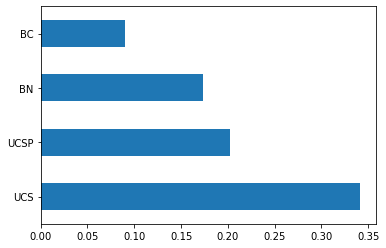

In [39]:
rf1.fit(df_x, df_y)
default_importances =rf1.feature_importances_
indices = np.argsort(default_importances)
feat_importances = pd.Series(rf1.feature_importances_, index=df_x.columns)
feat_importances.nlargest(4).plot(kind='barh')
plt.show()

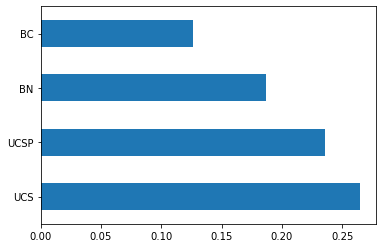

In [44]:
rf2.fit(df_x, df_y)
indices = np.argsort(rf2.feature_importances_)
feat_importances = pd.Series(rf2.feature_importances_, index=df_x.columns)
feat_importances.nlargest(4).plot(kind='barh')
plt.show()

> 과제<br/>
__중고차 가격 데이터를 바탕으로 랜덤포레스트 회귀분석을 실시하고, CV를 통한 최적의 하이퍼파라미터를 구한 다음 최적 모델의 변수 중요도를 계산하세요__